In [160]:
# will autoupdate any of the packages imported:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
import sys
sys.path.insert(0, '..')
import numpy as np
import matplotlib.pyplot as plt
import pyclifford as pc
import time

In [8]:
import seaborn as sns
sns.set_theme()

In [71]:
from numba import njit

# Global Clifford classical shadow tomography

In [166]:
N = 300
classical_shadows = []
num_of_shadow = 1000

In [167]:
circ = pc.Circuit(N)
# Create global Clifford random gate
circ.gate(*[i for i in range(N)])
for povm in circ.povm(num_of_shadow):
    state = pc.ghz_state(N)
    state.measure(povm)
    classical_shadows.append(state)

In [163]:
fidelity_predictions = []

In [164]:
for shadow in classical_shadows:
    fidelity_predictions.append(shadow.expect(pc.ghz_state(N))*(2**N)-1)

Text(0.5, 1.0, '300 qubit GHZ state')

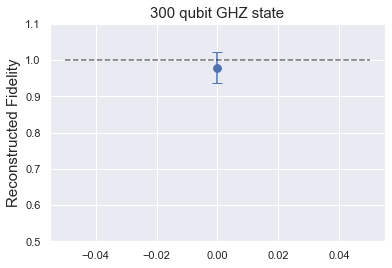

In [165]:
plt.errorbar(x = 0,y = np.mean(np.array(fidelity_predictions)),\
             yerr=np.std(np.array(fidelity_predictions))/np.sqrt(1000),capsize = 5)
plt.scatter(x = 0,y = np.mean(np.array(fidelity_predictions)),s= 60,)
plt.ylim([0.5,1.1])
plt.plot(np.linspace(-0.05,0.05,20),np.ones(20),"k--",alpha = 0.6)
plt.ylabel("Reconstructed Fidelity",fontsize = 15)
plt.title("300 qubit GHZ state",fontsize = 15)

# Shallow Circuit Shadow Classical

Let's study the classical shadow tomography with finite depth brick wall circuit. 

The reconstruction map has been studied under the formulation of locally scrambled classical shadow tomography.

First, let's get Pauli weights. By definition,

$
W(\vec{a})=\underset{U}{\mathbb{E}}\underset{b}{\mathbb{E}}|U^{\dagger}|b\rangle \langle b|U P_{\vec{a}}|^2
$

Another we to get the Pauli weights is through experimental calibration:

$W(\vec{a})=2^N\dfrac{\mathbb{E}\text{Tr}(\hat{\sigma}P_{\vec{a}})}{\text{Tr}(\rho P_{\vec{a}})}$

## Random Pauli measurement

In [67]:
N2 = 10

In [72]:
X = pc.pauli([1]+[0 for _ in range(N2-1)])
Z = pc.pauli([3]+[0 for _ in range(N2-1)])
XX = pc.pauli([1,1]+[0 for _ in range(N2-2)])
ZZ = pc.pauli([3,3]+[0 for _ in range(N2-2)])

In [68]:
def brickwall_circuit(N,depth):
    circ = pc.circuit.Circuit(N)
    for d in range(depth):
        for ii in range(int(N//2)):
            circ.gate(2*ii,2*ii+1)
        for ii in range(int(N//2)):
            circ.gate((2*ii+1),(2*ii+2)%N)
    return circ

In [69]:
def random_pauli_circuit(N):
    circ = pc.circuit.Circuit(N)
    for ii in range(N):
        circ.gate(ii)
    return circ

In [88]:
circ = random_pauli_circuit(N2)
classical_shadows2 = []
num_of_shadow = 10000
for povm in circ.povm(num_of_shadow):
    state = pc.stabilizer.zero_state(N2)
    state.measure(povm)
    classical_shadows2.append(state)

In [102]:
Wz_lst = []
for i in range(num_of_shadow):
    Wz_lst.append(np.real(classical_shadows2[i].expect(Z)))
Wzz_lst = []
for i in range(num_of_shadow):
    Wzz_lst.append(np.real(classical_shadows2[i].expect(ZZ)))
Wx_lst = []
for i in range(num_of_shadow):
    Wx_lst.append(np.real(classical_shadows2[i].expect(X)))

In [103]:
Wz = (2**N2)*np.mean(np.array(Wz_lst))
Wzz = (2**N2)*np.mean(np.array(Wzz_lst))

In [105]:
circ = random_pauli_circuit(N2)
classical_shadows_test = []
num_of_shadow = 1000
for povm in circ.povm(num_of_shadow):
    state = pc.stabilizer.ghz_state(N2)
    state.measure(povm)
    classical_shadows_test.append(state)

Predict ZZ operator:

In [110]:
predict_zzs = []
for i in range(len(classical_shadows_test)):
    predict_zzs.append(np.real(classical_shadows_test[i].expect(ZZ)))
predict_zs = []
for i in range(len(classical_shadows_test)):
    predict_zs.append(np.real(classical_shadows_test[i].expect(Z)))

In [109]:
np.mean(np.array(predict_zzs))*(2**N2)/Wzz

0.954954954954955

Text(0.5, 1.0, '10 qubit GHZ state (randomized Pauli measurement)')

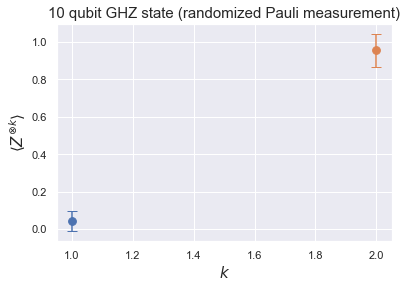

In [118]:
plt.errorbar(x = 1,y = np.mean(np.array(predict_zs))*(2**N2)/Wz,\
             yerr=np.std(np.array(predict_zs))*(2**N2)/(Wz*np.sqrt(1000)),capsize = 5)
plt.scatter(x = 1,y = np.mean(np.array(predict_zs))*(2**N2)/Wz,s= 60,)
plt.errorbar(x = 2,y = np.mean(np.array(predict_zzs))*(2**N2)/Wzz,\
             yerr=np.std(np.array(predict_zzs))*(2**N2)/(Wzz*np.sqrt(1000)),capsize = 5)
plt.scatter(x = 2,y = np.mean(np.array(predict_zzs))*(2**N2)/Wzz,s= 60,)

# plt.ylim([0.8,1.1])
# plt.plot(np.linspace(-0.05,0.05,20),np.ones(20),"k--",alpha = 0.6)
plt.xlabel(r"$k$",fontsize = 15)
plt.ylabel(r"$\langle Z^{\otimes k}\rangle$",fontsize = 15)
plt.title("10 qubit GHZ state (randomized Pauli measurement)",fontsize = 15)

## Shallow layer brickwall circuit

In [135]:
circ = brickwall_circuit(N2,3)
classical_shadows3 = []
num_of_shadow = 50000
for povm in circ.povm(num_of_shadow):
    state = pc.stabilizer.zero_state(N2)
    state.measure(povm)
    classical_shadows3.append(state)

In [136]:
Wz_lst = []
for i in range(num_of_shadow):
    Wz_lst.append(np.real(classical_shadows3[i].expect(Z)))
Wzz_lst = []
for i in range(num_of_shadow):
    Wzz_lst.append(np.real(classical_shadows3[i].expect(ZZ)))

In [144]:
circ = brickwall_circuit(N2,3)
classical_shadows_test = []
num_of_shadow = 10000
for povm in circ.povm(num_of_shadow):
    state = pc.stabilizer.ghz_state(N2)
    state.measure(povm)
    classical_shadows_test.append(state)

In [145]:
predict_zzs = []
for i in range(len(classical_shadows_test)):
    predict_zzs.append(np.real(classical_shadows_test[i].expect(ZZ)))
predict_zs = []
for i in range(len(classical_shadows_test)):
    predict_zs.append(np.real(classical_shadows_test[i].expect(Z)))

Text(0.5, 1.0, '10 qubit GHZ state (3 layer brickwall circuit)')

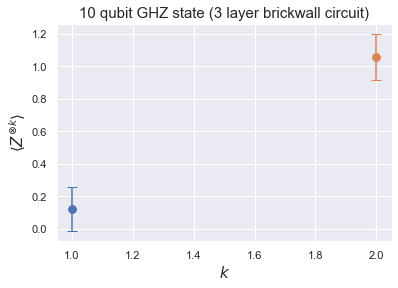

In [148]:
plt.errorbar(x = 1,y = np.mean(np.array(predict_zs))*(2**N2)/Wz,\
             yerr=np.std(np.array(predict_zs))*(2**N2)/(Wz*np.sqrt(5000)),capsize = 5)
plt.scatter(x = 1,y = np.mean(np.array(predict_zs))*(2**N2)/Wz,s= 60,)
plt.errorbar(x = 2,y = np.mean(np.array(predict_zzs))*(2**N2)/Wzz,\
             yerr=np.std(np.array(predict_zzs))*(2**N2)/(Wzz*np.sqrt(5000)),capsize = 5)
plt.scatter(x = 2,y = np.mean(np.array(predict_zzs))*(2**N2)/Wzz,s= 60,)

# plt.ylim([0.8,1.1])
# plt.plot(np.linspace(-0.05,0.05,20),np.ones(20),"k--",alpha = 0.6)
plt.xlabel(r"$k$",fontsize = 15)
plt.ylabel(r"$\langle Z^{\otimes k}\rangle$",fontsize = 15)
plt.title("10 qubit GHZ state (3 layer brickwall circuit)",fontsize = 15)

# Test

In [62]:
Wx_lst = []
for _ in range(10000):
    state = pc.stabilizer.random_bit_state(N2)
    circ.backward(state)
    Wx_lst.append(abs(state.expect(X))**2)
Wx = np.mean(np.array(Wx_lst))

In [63]:
1/Wx

2.9797377830750893

In [64]:
Wz_lst = []
for _ in range(10000):
    state = pc.stabilizer.random_bit_state(N2)
    circ.backward(state)
    Wz_lst.append(abs(state.expect(Z))**2)
Wz = np.mean(np.array(Wz_lst))
Wxx_lst = []
for _ in range(10000):
    state = pc.stabilizer.random_bit_state(N2)
    circ.backward(state)
    Wxx_lst.append(abs(state.expect(XX))**2)
Wxx = np.mean(np.array(Wxx_lst))
Wzz_lst = []
for _ in range(10000):
    state = pc.stabilizer.random_bit_state(N2)
    circ.backward(state)
    Wzz_lst.append(abs(state.expect(ZZ))**2)
Wzz = np.mean(np.array(Wzz_lst))

In [65]:
1/Wxx

9.19963201471941

In [66]:
1/Wzz

8.347245409015025